In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

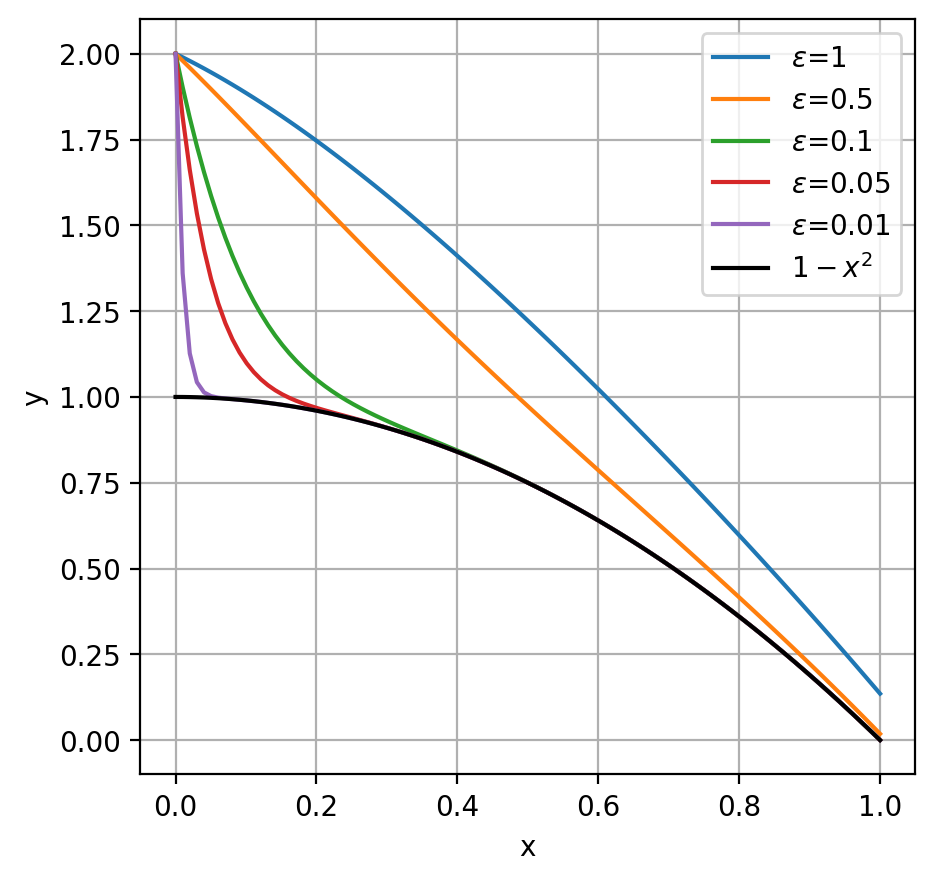

In [2]:
x = np.linspace(0,1,100)
x = np.array([x]).T

def solution(x,e):
    return np.exp(-(x*x+x)/e) - x**2 + 1

plt.figure(figsize=(5,5),dpi=200)
plt.plot(x,solution(x,1),label='$\epsilon$=1')
plt.plot(x,solution(x,0.5),label='$\epsilon$=0.5')
plt.plot(x,solution(x,0.1),label='$\epsilon$=0.1')
plt.plot(x,solution(x,0.05),label='$\epsilon$=0.05')
plt.plot(x,solution(x,0.01),label='$\epsilon$=0.01')
plt.plot(x,1-x**2,label='$1-x^2$',c='k')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

e = 0.01
y = solution(x,e)
x_i = np.array([[0]],dtype='float')
y_i = np.array([[2]],dtype='float')
x_f = lhs(1, 10000)
x_i = tf.constant(x_i,dtype=tf.float32)
x_f = tf.constant(x_f,dtype=tf.float32)
y_i = tf.constant(y_i,dtype=tf.float32)
x = tf.constant(x,dtype=tf.float32)
y = tf.constant(y,dtype=tf.float32)

In [3]:
def new_PINN(model,index_1,index_2):
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)
    count = 0
    idx = []
    part = []
    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n
    part = tf.constant(part)
    pinn_params_last_index = idx[-1].numpy()[0]
    
    index_1_shapes = tf.shape_n(index_1.trainable_variables)
    index_1_n_tensors = len(index_1_shapes)
    index_1_count = 0
    index_1_idx = []
    index_1_part = []
    for i, shape in enumerate(index_1_shapes):
        n = np.product(shape)
        index_1_idx.append(tf.reshape(tf.range(index_1_count, index_1_count+n, dtype=tf.int32), shape))
        index_1_part.extend([i]*n)
        index_1_count += n
    index_1_part = tf.constant(index_1_part)
    
    index_2_shapes = tf.shape_n(index_2.trainable_variables)
    index_2_n_tensors = len(index_2_shapes)
    index_2_count = 0
    index_2_idx = []
    index_2_part = []
    for i, shape in enumerate(index_2_shapes):
        n = np.product(shape)
        index_2_idx.append(tf.reshape(tf.range(index_2_count, index_2_count+n, dtype=tf.int32), shape))
        index_2_part.extend([i]*n)
        index_2_count += n
    index_2_part = tf.constant(index_2_part)
    
    index_1_params_last_index = index_1_idx[-1].numpy()[0]
    index_2_params_last_index = index_2_idx[-1].numpy()[0]

    @tf.function
    def assign_new_model_parameters(pinn_params_1d):
        params = tf.dynamic_partition(pinn_params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))
    
    @tf.function
    def assign_new_index_1_parameters(index_1_params_1d):
        params = tf.dynamic_partition(index_1_params_1d, index_1_part, index_1_n_tensors)
        for i, (shape, param) in enumerate(zip(index_1_shapes, params)):
            index_1.trainable_variables[i].assign(tf.reshape(param, shape))
    
    @tf.function
    def assign_new_index_2_parameters(index_2_params_1d):
        params = tf.dynamic_partition(index_2_params_1d, index_2_part, index_2_n_tensors)
        for i, (shape, param) in enumerate(zip(index_2_shapes, params)):
            index_2.trainable_variables[i].assign(tf.reshape(param, shape))
    
    @tf.function
    def f(params_1d):
        c2 = tf.reshape(params_1d[-2],(1,))
        c1 = tf.reshape(params_1d[-1],(1,))
        pinn_params_1d = params_1d[:pinn_params_last_index+1]
        index_1_params_1d = params_1d[pinn_params_last_index+1:pinn_params_last_index+index_1_params_last_index+2]
        index_2_params_1d = params_1d[pinn_params_last_index+index_1_params_last_index+2:pinn_params_last_index+index_1_params_last_index+index_2_params_last_index+3]
        with tf.GradientTape() as tape:
            tape.watch([model.trainable_variables,index_1.trainable_variables,index_2.trainable_variables,c2,c1])
            assign_new_model_parameters(pinn_params_1d)
            assign_new_index_1_parameters(index_1_params_1d)
            assign_new_index_2_parameters(index_2_params_1d)
            loss_value = Loss_new_PINN(model,index_1,index_2,c1,c2)
        grads = tape.gradient(loss_value, [model.trainable_variables,index_1.trainable_variables,index_2.trainable_variables,c2,c1])
        pinn_grads = tf.dynamic_stitch(idx, grads[0])
        index_1_grads = tf.dynamic_stitch(index_1_idx, grads[1])
        index_2_grads = tf.dynamic_stitch(index_2_idx, grads[2])
        newgrads = tf.concat([pinn_grads,index_1_grads,index_2_grads,grads[3],grads[4]],0)
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])
        return loss_value, newgrads
    
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    
    f.index_1_idx = index_1_idx
    f.index_1_part = index_1_part
    f.index_1_shapes = index_1_shapes
    f.assign_new_index_1_parameters = assign_new_index_1_parameters
    
    f.index_2_idx = index_2_idx
    f.index_2_part = index_2_part
    f.index_2_shapes = index_2_shapes
    f.assign_new_index_2_parameters = assign_new_index_2_parameters
    
    f.history = []

    return f

def Loss_new_PINN(model,index_1,index_2,c1,c2):
    with tf.GradientTape() as tape:
        tape.watch(x_f)
        y_pred_f = model.call(x_f)
        y_pred_f += c1*tf.exp(index_1.call((x_f-1)/e)) + c2*tf.exp(index_2.call(-x_f/e))
        y_x = tape.gradient(y_pred_f,x_f)
    y_pred_i = model.call(x_i)
    y_pred_i += c1*tf.exp(index_1.call((x_i-1)/e)) + c2*tf.exp(index_2.call(-x_i/e))
    F = e*y_x - (2*x_f+1)*y_pred_f - (2*(x_f**3)+x_f**2-(2*e+2)*x_f-1)
    loss = tf.reduce_mean(tf.square(y_i-y_pred_i)) + tf.reduce_mean(tf.square(F))
    return loss


def PINN(model):
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)
    count = 0
    idx = []
    part = []
    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n
    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    @tf.function
    def f(params_1d):
        with tf.GradientTape() as tape:
            tape.watch(model.trainable_variables)
            assign_new_model_parameters(params_1d)
            loss_value = loss_PINN(model)
        grads = tape.gradient(loss_value, model.trainable_variables)
        newgrads = tf.dynamic_stitch(idx, grads)
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])
        return loss_value, newgrads
    
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f


def loss_PINN(model):
    with tf.GradientTape() as tape:
        tape.watch(x_f)
        y_pred_f = model.call(x_f)
        y_x = tape.gradient(y_pred_f,x_f)
    y_pred_i = model.call(x_i)
    F = e*y_x - (2*x_f+1)*y_pred_f - (2*(x_f**3)+x_f**2-(2*e+2)*x_f-1)    
    loss = tf.reduce_mean(tf.square(y_i-y_pred_i)) + tf.reduce_mean(tf.square(F))
    return loss

model = keras.models.Sequential([
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1)
])
model.call(x_f)

index_1 = keras.models.Sequential([
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1)
])
index_1.call(x_f)

index_2 = keras.models.Sequential([
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1)
])
index_2.call(x_f)

model_pinn = keras.models.Sequential([
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1)
])
model_pinn.call(x_f)


newpinn = new_PINN(model,index_1,index_2)
ic1 = tf.Variable([0.])
ic2 = tf.Variable([0.])
init_pinn_params = tf.dynamic_stitch(newpinn.idx, model.trainable_variables)
init_index_1_params = tf.dynamic_stitch(newpinn.index_1_idx, index_1.trainable_variables)
init_index_2_params = tf.dynamic_stitch(newpinn.index_2_idx, index_2.trainable_variables)
params = tf.concat([init_pinn_params,init_index_1_params,init_index_2_params,ic2,ic1],0)
final_params = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=newpinn, initial_position=params, max_iterations=1000)

pinn = PINN(model_pinn)
#init_pinn_params = tf.dynamic_stitch(pinn.idx, model_pinn.trainable_variables)
final_pinn_params = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=pinn, initial_position=init_pinn_params, max_iterations=1000)

c1_pred = final_params.position[-1].numpy()
c2_pred = final_params.position[-2].numpy()

pred = model.predict(x) + c1_pred*tf.exp(index_1.predict((x-1)/e)) + c2_pred*tf.exp(index_2.predict(-x/e))
res = y - pred
pinn_pred = model_pinn.predict(x)
res_pinn = y - pinn_pred

Iter: 1 loss: 6.69514751
Iter: 2 loss: 38350.168
Iter: 3 loss: 11.7777214
Iter: 4 loss: 1.44753408
Iter: 5 loss: 1.36181939
Iter: 6 loss: 1.0908879
Iter: 7 loss: 1.8919816
Iter: 8 loss: 0.928679883
Iter: 9 loss: 0.333681375
Iter: 10 loss: 3.68164062
Iter: 11 loss: 0.179997295
Iter: 12 loss: 0.175254479
Iter: 13 loss: 0.135443196
Iter: 14 loss: 0.134226367
Iter: 15 loss: 0.152040198
Iter: 16 loss: 0.134222522
Iter: 17 loss: 0.132997945
Iter: 18 loss: 0.128188193
Iter: 19 loss: 0.106745884
Iter: 20 loss: 0.220364988
Iter: 21 loss: 0.094600752
Iter: 22 loss: 0.153309643
Iter: 23 loss: 0.0811733
Iter: 24 loss: 0.0613686927
Iter: 25 loss: 0.060421221
Iter: 26 loss: 0.0473658703
Iter: 27 loss: 0.14933379
Iter: 28 loss: 0.0466759913
Iter: 29 loss: 0.0458727032
Iter: 30 loss: 0.0611048825
Iter: 31 loss: 0.0458721519
Iter: 32 loss: 0.0457976907
Iter: 33 loss: 0.0466704
Iter: 34 loss: 0.045796629
Iter: 35 loss: 0.04562857
Iter: 36 loss: 0.0450180918
Iter: 37 loss: 0.0432494842
Iter: 38 loss: 0.1

Iter: 291 loss: 0.0199084412
Iter: 292 loss: 0.0199081786
Iter: 293 loss: 0.0199081376
Iter: 294 loss: 0.0199078284
Iter: 295 loss: 0.0199090876
Iter: 296 loss: 0.01990778
Iter: 297 loss: 0.0199074205
Iter: 298 loss: 0.0199119784
Iter: 299 loss: 0.0199073795
Iter: 300 loss: 0.0199068096
Iter: 301 loss: 0.019909624
Iter: 302 loss: 0.0199067295
Iter: 303 loss: 0.0199060533
Iter: 304 loss: 0.0199189633
Iter: 305 loss: 0.0199059751
Iter: 306 loss: 0.0199034233
Iter: 307 loss: 0.0201591142
Iter: 308 loss: 0.0199034158
Iter: 309 loss: 0.0199027713
Iter: 310 loss: 0.019902017
Iter: 311 loss: 0.0199000556
Iter: 312 loss: 0.0199000333
Iter: 313 loss: 0.0198969431
Iter: 314 loss: 0.0200122576
Iter: 315 loss: 0.0198969115
Iter: 316 loss: 0.0198968295
Iter: 317 loss: 0.0198950488
Iter: 318 loss: 0.0198940281
Iter: 319 loss: 0.0199113786
Iter: 320 loss: 0.0198939554
Iter: 321 loss: 0.0198933166
Iter: 322 loss: 0.019895589
Iter: 323 loss: 0.0198931079
Iter: 324 loss: 0.0198937543
Iter: 325 loss: 0.0

Iter: 576 loss: 0.0198586658
Iter: 577 loss: 0.0198586937
Iter: 578 loss: 0.0198586695
Iter: 579 loss: 0.0198586918
Iter: 580 loss: 0.0198586676
Iter: 581 loss: 0.0198586546
Iter: 582 loss: 0.0198586341
Iter: 583 loss: 0.0198586434
Iter: 584 loss: 0.019858649
Iter: 585 loss: 0.0198586341
Iter: 586 loss: 0.0198586397
Iter: 587 loss: 0.0198586602
Iter: 588 loss: 0.0198586397
Iter: 589 loss: 0.0198586546
Iter: 590 loss: 0.0198586825
Iter: 591 loss: 0.019858649
Iter: 592 loss: 0.0198586881
Iter: 593 loss: 0.0198586844
Iter: 594 loss: 0.0198586881
Iter: 595 loss: 0.01985869
Iter: 596 loss: 0.0198586881
Iter: 597 loss: 0.0198586918
Iter: 598 loss: 0.0198586918
Iter: 599 loss: 0.0198586918
Iter: 600 loss: 0.0198586881
Iter: 601 loss: 0.0198586881
Iter: 602 loss: 0.0198586918
Iter: 603 loss: 0.0198586881
Iter: 604 loss: 0.0198586918
Iter: 605 loss: 0.0198585149
Iter: 606 loss: 0.0198584851
Iter: 607 loss: 0.0198583771
Iter: 608 loss: 0.0198605452
Iter: 609 loss: 0.0198583808
Iter: 610 loss: 0.

Iter: 27 loss: 0.25603345
Iter: 28 loss: 0.19080852
Iter: 29 loss: 0.187328666
Iter: 30 loss: 0.184433296
Iter: 31 loss: 0.17958045
Iter: 32 loss: 0.344702452
Iter: 33 loss: 0.179523125
Iter: 34 loss: 0.172537148
Iter: 35 loss: 0.160819352
Iter: 36 loss: 1.70664239
Iter: 37 loss: 0.160625428
Iter: 38 loss: 0.167045176
Iter: 39 loss: 0.159776449
Iter: 40 loss: 0.158297777
Iter: 41 loss: 0.173049167
Iter: 42 loss: 0.158043504
Iter: 43 loss: 0.156758219
Iter: 44 loss: 0.163833931
Iter: 45 loss: 0.156717345
Iter: 46 loss: 0.1620415
Iter: 47 loss: 0.155874908
Iter: 48 loss: 0.154983908
Iter: 49 loss: 0.154961586
Iter: 50 loss: 0.154854134
Iter: 51 loss: 0.156999424
Iter: 52 loss: 0.154852733
Iter: 53 loss: 0.154748067
Iter: 54 loss: 0.155694857
Iter: 55 loss: 0.154743806
Iter: 56 loss: 0.154731
Iter: 57 loss: 0.154823586
Iter: 58 loss: 0.154729843
Iter: 59 loss: 0.154726744
Iter: 60 loss: 0.154718831
Iter: 61 loss: 0.154790223
Iter: 62 loss: 0.15471755
Iter: 63 loss: 0.154696852
Iter: 64 lo

Iter: 320 loss: 0.0353678241
Iter: 321 loss: 0.0350388549
Iter: 322 loss: 0.0350897461
Iter: 323 loss: 0.0350272357
Iter: 324 loss: 0.0350191146
Iter: 325 loss: 0.0350187384
Iter: 326 loss: 0.0350164175
Iter: 327 loss: 0.0350168869
Iter: 328 loss: 0.0350139514
Iter: 329 loss: 0.0350193381
Iter: 330 loss: 0.0350135081
Iter: 331 loss: 0.0353088155
Iter: 332 loss: 0.0350145698
Iter: 333 loss: 0.0350147337
Iter: 334 loss: 0.0350149684
Iter: 335 loss: 0.0350153223
Iter: 336 loss: 0.0350134484
Iter: 337 loss: 0.0350142159
Iter: 338 loss: 0.0350140706
Iter: 339 loss: 0.0350146
Iter: 340 loss: 0.0350134224
Iter: 341 loss: 0.035014797
Iter: 342 loss: 0.035014905
Iter: 343 loss: 0.0350135379
Iter: 344 loss: 0.0350134745
Iter: 345 loss: 0.0350126624
Iter: 346 loss: 0.0350148603
Iter: 347 loss: 0.0350137204
Iter: 348 loss: 0.0350130647
Iter: 349 loss: 0.0350130573
Iter: 350 loss: 0.0350138955
Iter: 351 loss: 0.0350138545
Iter: 352 loss: 0.0350130573
Iter: 353 loss: 0.0350130573
Iter: 354 loss: 0.0

epsilon = 0.01
c1,c2 = 0.3588292 1.0383275


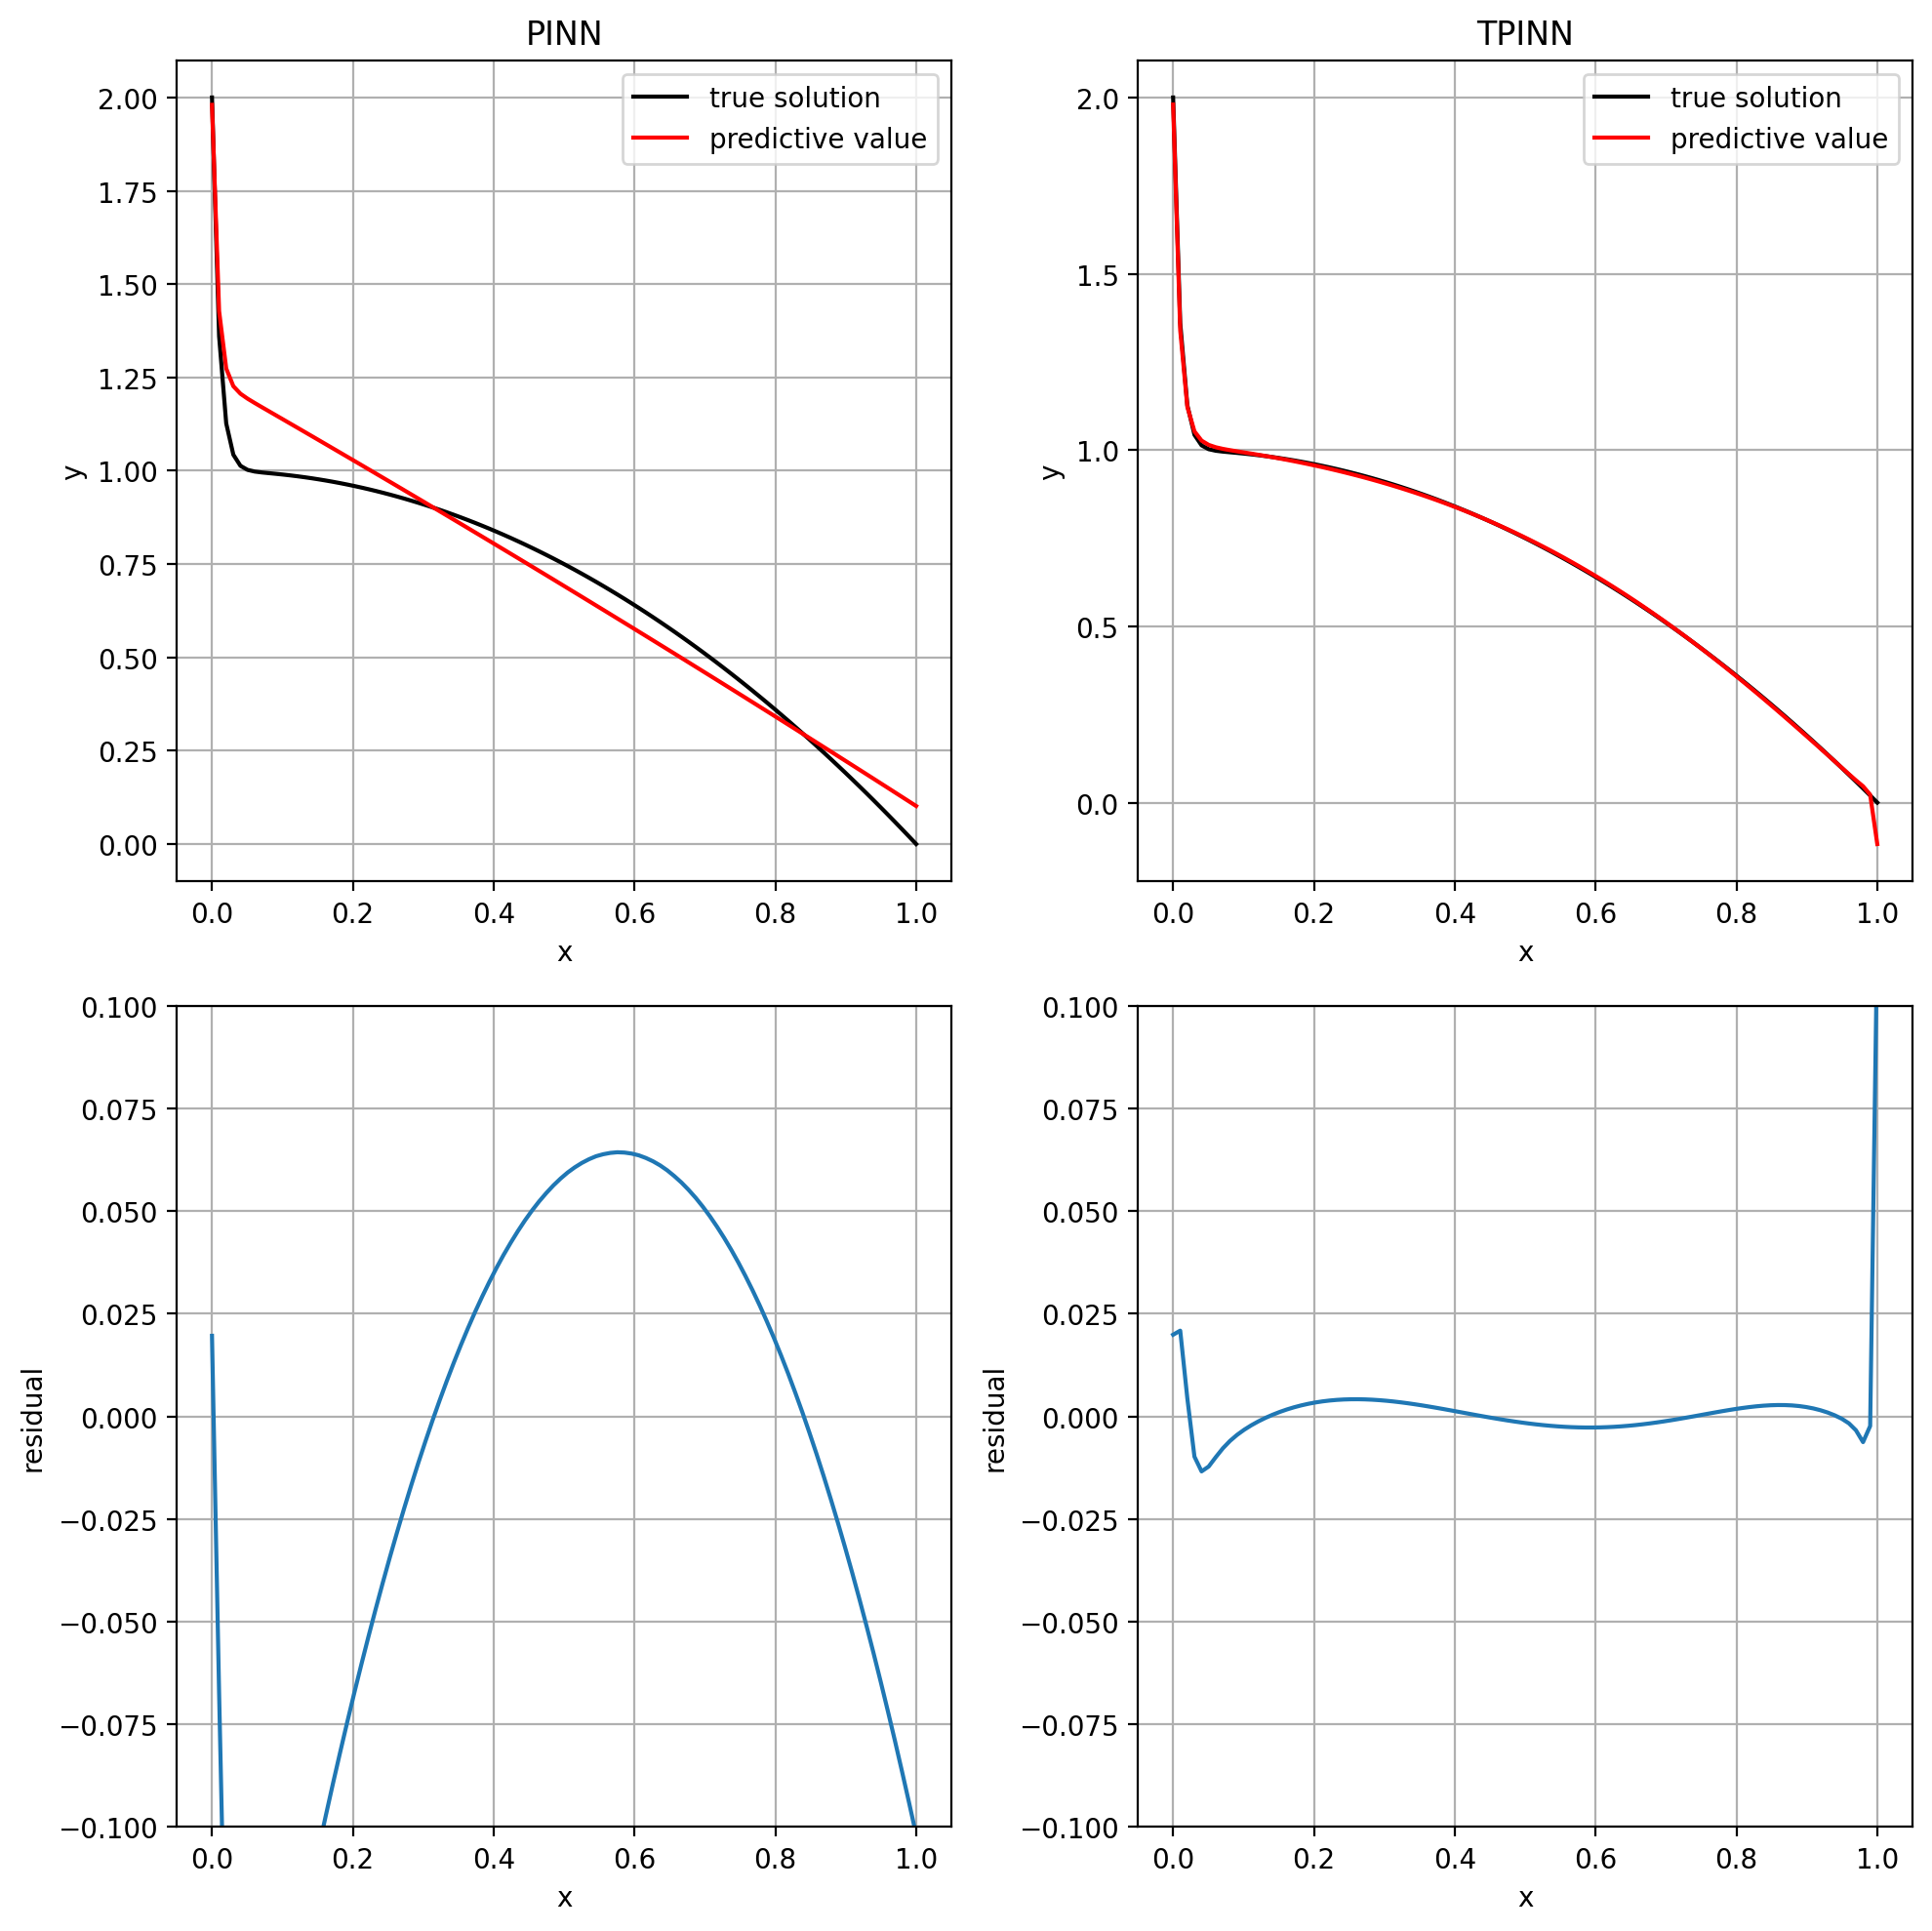

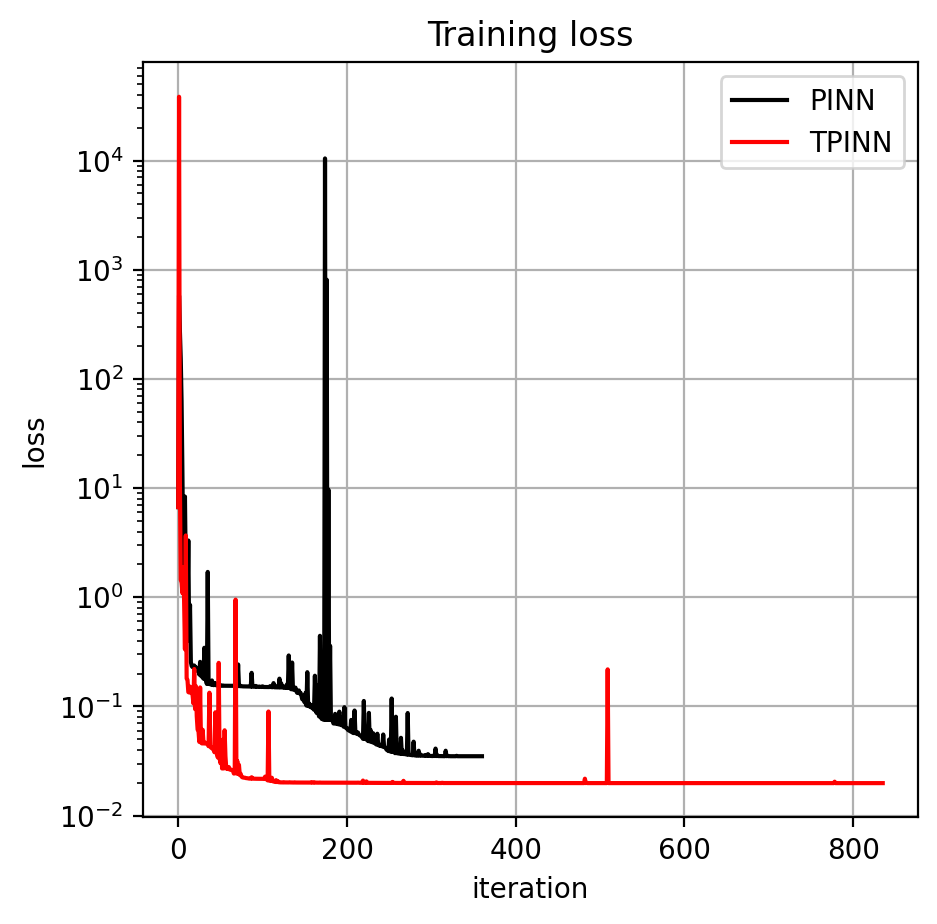

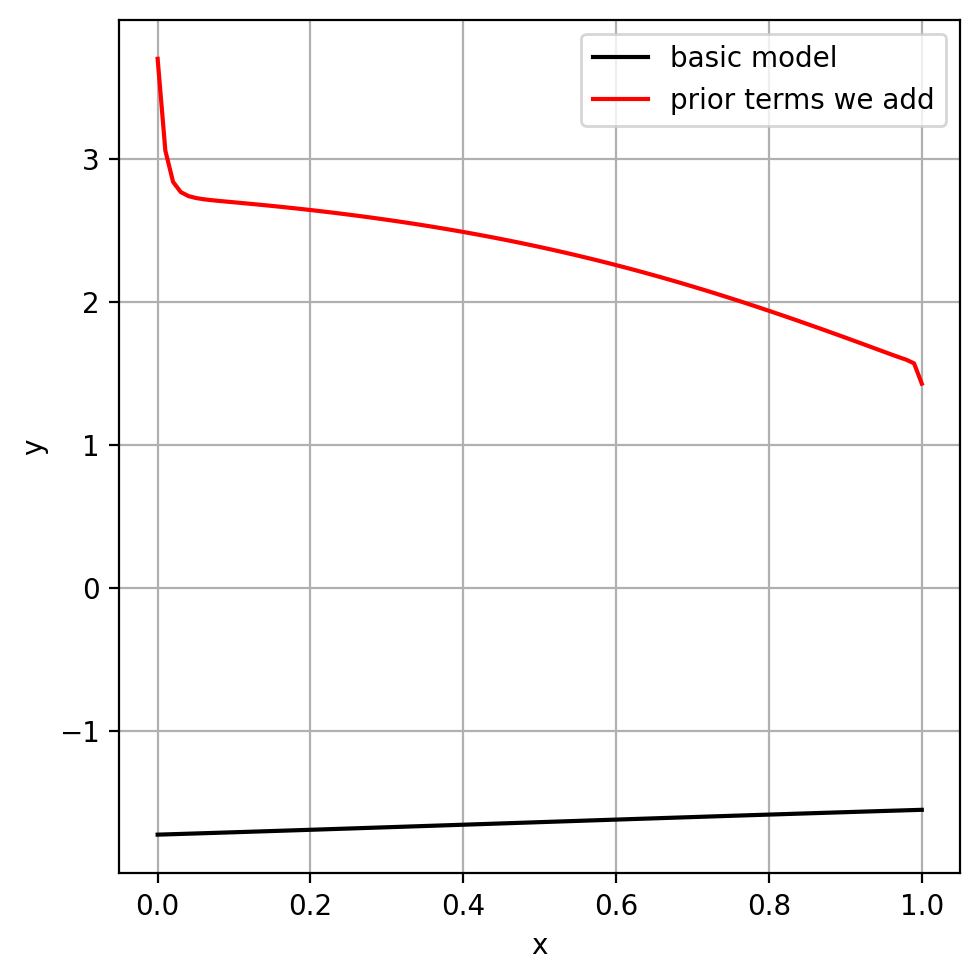

In [4]:
print('epsilon =',e)
print('c1,c2 =',c1_pred,c2_pred)

plt.figure(figsize=(10,10),dpi=200)
plt.subplot(2,2,1)
plt.title('PINN')
plt.plot(x,y,color='k',label='true solution')
plt.plot(x,pinn_pred,color='r',label='predictive value')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.subplot(2,2,2)
plt.title('TPINN')
plt.plot(x,y,color='k',label='true solution')
plt.plot(x,pred,color='r',label='predictive value')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.subplot(2,2,3)
plt.plot(x,res_pinn)
plt.ylim((-0.1,0.1))
plt.xlabel('x')
plt.ylabel('residual')
plt.grid()
plt.subplot(2,2,4)
plt.plot(x,res)
plt.ylim((-0.1,0.1))
plt.xlabel('x')
plt.ylabel('residual')
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5),dpi=200)
plt.title('Training loss')
plt.plot(pinn.history,color='k',label='PINN')
plt.plot(newpinn.history,color='r',label='TPINN')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale('log')
plt.grid()
plt.show()

plt.figure(figsize=(5,5),dpi=200)
plt.plot(x,model.predict(x),c='k',label='basic model')
plt.plot(x,c1_pred*tf.exp(index_1.predict((x-1)/e)) + c2_pred*tf.exp(index_2.predict(-x/e)),c='r',label='prior terms we add')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()